In [86]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 데이터 불러오기
- News_Summary 데이터 불러오기

In [87]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 데이터 전처리

In [88]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


* 데이터 설명
    - 헤드라인과 본문으로 이루어져있음
    - 헤드라인 = Summary로 보고 text = Text로 진행

In [89]:
data = data[['text','headlines']]
data.rename(columns  = {'text': 'Text'}, inplace = True)
data.rename(columns  = {'headlines': 'Summary'}, inplace = True)

data.head()


#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
28028,A section of fans threw eggs and cushions at t...,"Eggs, cushions thrown at S Korean squad upon r..."
37618,Filmmaker Vishal Bhardwaj has said that he wan...,Want Priyanka in my film based on play Twelfth...
77261,"Sukhbir Singh, a 33-year-old Singaporean Sikh ...",Sikh referee racially abused while officiating...
24882,A day after government slashed the GST rates o...,Govt cut GST rates with eye on assembly polls:...
96931,"Comedian Kiku Sharda, who plays 'Bumper' on 'T...","Kapil said nothing to me, I'm still part of th..."
76312,A study of 128 brain regions involving over 26...,Women have more active brains than men: Study
58030,Colombian weightlifter Edwin Mosquera Roa was ...,Colombian Olympic lifter shot dead after argum...
87285,"Filmmaker Karan Johar, while speaking about th...",Baahubali director is now India's biggest supe...
46237,"Boxing legend Muhammad Ali, who was then known...",Ali was first crowned heavyweight world champi...
21231,"A 52-year-old man named Yogesh Kumar, who clai...",Man who met late PM Vajpayee in 1984 travels 5...


In [90]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [91]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 중복값을 제거했지만 Null 값이 있을 수도 있으니 dropna로 확실하게 처리(axis=0 --> 해당 행 삭제)

In [92]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


* null값을 가지는 행은 없었나보다

In [93]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [94]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 데이터 전처리 함수 정의

In [95]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [96]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


### 데이터 전처리 함수 실행(느린 예)

In [97]:
# clean_text = []
# # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# for s in data['Text']:
#     clean_text.append(preprocess_sentence(s))

# # 전처리 후 출력
# print(clean_text[:5])


# clean_summary = []
# # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
# for s in data['Summary']:
#     clean_summary.append(preprocess_sentence(s, False))

# print(clean_summary[:5])



### 데이터 전처리 함수 실행(멀티 프로세싱 사용 --> 빠른 예)

In [98]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_summary)

180.40513229370117  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [99]:
mp.cpu_count()

6

* cpu개수가 6대인걸 확인할 수 있다.
    - 6배는 빨라질거야!

In [100]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

* 텍스트 정제 과정에서 empty 샘플이 생길 수 있음
    - 빈 값을 가진 샘플 -> Null로 교체

In [101]:
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [102]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 샘플 개수 유지 --> Text 정제 이후에도 null된 데이터 없음

# 데이터 전처리 - 훈련/테스트 데이터 나누기

## 텍스트와 요약의 길이 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


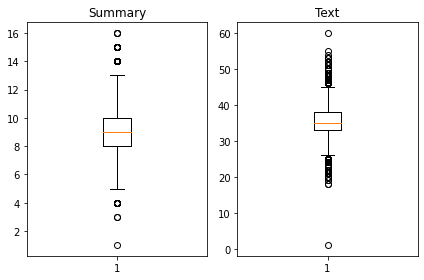

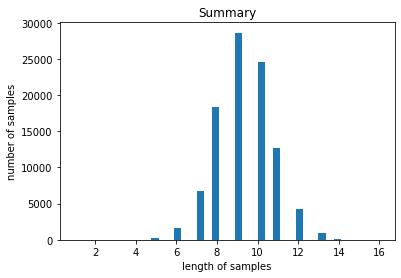

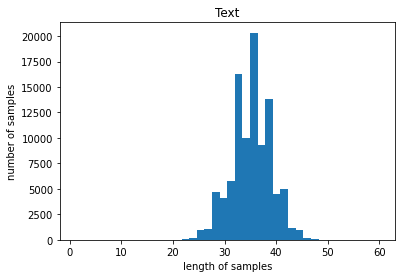

In [103]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## text와 summary의 길이 제한을 줬을 때 샘플이 얼마나 잘리는지 확인

In [104]:
text_max_len = 40
summary_max_len = 10

In [105]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [106]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [107]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


### apply함수 어떻게 적용되는지 확인용 

In [130]:
apply_test = data.copy()

In [131]:
apply_test = data_test[:30]
apply_test

,Text,Summary
22,least people killed others injured saudi arabi...,killed injured in saudi arabia floods
37,afghan president ashraf ghani said keys war pa...,pakistan holds keys to war afghanistan
41,swedish multinational fast fashion brand henne...,fashion brand hires facebook data scandal whis...


In [132]:
apply_test = apply_test[apply_test['Text'].apply(lambda x: len(x.split()) <=40)]
apply_test = apply_test[apply_test['Summary'].apply(lambda x: len(x.split()) <= 7)]
apply_test

,Text,Summary
22,least people killed others injured saudi arabi...,killed injured in saudi arabia floods
37,afghan president ashraf ghani said keys war pa...,pakistan holds keys to war afghanistan
41,swedish multinational fast fashion brand henne...,fashion brand hires facebook data scandal whis...


In [133]:
len(apply_test)

3

* apply 함수
    - apply함수를 통해 lambda식을 만족하는 행만 True로 바뀌고 그걸 다시 데이터에 넣으니 True 행만 추출하는 방식

In [134]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll in rajasthan takes to...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,two minor cousins uttar pradesh gorakhpur alle...,up cousins fed human excreta for friendship wi...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [135]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련/테스트 데이터를 분리하는 방법 - 직접 코딩
 - encoder_input데이터와 크기, 형태가 같은 순서가 섞인 정수 시퀀스 만들기
 - 2:8로 데이터 분리
 - test는 행벡터, train은 열벡터로 분리

In [136]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[62634 29235 26591 ...  7135 59599 53006]


In [137]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [138]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [139]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


# 데이터 전처리 - 정수 인코딩

In [140]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- train 데이터 인코딩

In [141]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61602
등장 빈도가 6번 이하인 희귀 단어의 수: 42301
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19301
단어 집합에서 희귀 단어의 비율: 68.66822505762799
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.195601244969322


- 등장빈도가 낮은 단어가 train데이터 셋에 얼마나 들어있는지 확인
    - rare한 단어는 74퍼센트 / 빈도가 높은 편인 단어는 26버센트임을 알 수 있다.

In [142]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [143]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[616, 408, 14, 84, 1578, 4522, 170, 4673, 347, 486, 63, 5259, 960, 544, 820, 77, 164, 17, 3663, 2436, 847, 761, 121, 402, 3350, 51, 101, 90, 3664, 14, 335, 761, 253], [617, 365, 511, 285, 6153, 290, 2751, 379, 20, 279, 3249, 100, 479, 617, 490, 625, 244, 1243], [27, 36, 2720, 104, 27, 7, 1676, 7405, 848, 2034, 1370, 7, 5972, 812, 2098, 4, 1213, 7, 396, 11, 253, 38, 142, 760, 5114, 4572, 6906, 7]]


- text_to_sequences()는 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

## 타겟 train 데이터도 같은 작업

In [144]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [145]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27274
등장 빈도가 5번 이하인 희귀 단어의 수: 18228
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9046
단어 집합에서 희귀 단어의 비율: 66.83288113221383
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9747218684672125


In [146]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 387, 624, 59, 649, 12, 1136], [1, 501, 853, 444, 72, 17, 1258, 5, 439], [1, 50, 113, 5, 821, 1187], [1, 63, 307, 1560, 239, 18, 25, 19, 697, 650], [1, 342, 428, 693, 10, 212, 19, 17]]
target
decoder  [[387, 624, 59, 649, 12, 1136, 2], [501, 853, 444, 72, 17, 1258, 5, 439, 2], [50, 113, 5, 821, 1187, 2], [63, 307, 1560, 239, 18, 25, 19, 697, 650, 2], [342, 428, 693, 10, 212, 19, 17, 2]]


## 빈도수 낮은 데이터는 사라짐
- len = 1일것임 (sostoken, eostoken이 남아있을 것)
- 이런 샘플들을 삭제하자

In [147]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 59272
훈련 레이블의 개수 : 59272
테스트 데이터의 개수 : 14818
테스트 레이블의 개수 : 14818


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [148]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 모델 설계하기

In [149]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [150]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [151]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 어텐션 메커니즘

In [152]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [153]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [154]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 142s 564ms/step - loss: 4.7603 - val_loss: 4.1076
Epoch 2/50
232/232 [==============================] - 129s 558ms/step - loss: 4.0321 - val_loss: 3.8040
Epoch 3/50
232/232 [==============================] - 129s 557ms/step - loss: 3.7204 - val_loss: 3.5867
Epoch 4/50
232/232 [==============================] - 129s 555ms/step - loss: 3.4979 - val_loss: 3.4294
Epoch 5/50
232/232 [==============================] - 127s 549ms/step - loss: 3.3349 - val_loss: 3.3037
Epoch 6/50
232/232 [==============================] - 125s 539ms/step - loss: 3.1999 - val_loss: 3.2085
Epoch 7/50
232/232 [==============================] - 125s 538ms/step - loss: 3.0799 - val_loss: 3.1265
Epoch 8/50
232/232 [==============================] - 125s 539ms/step - loss: 2.9702 - val_loss: 3.0632
Epoch 9/50
232/232 [==============================] - 125s 539ms/step - loss: 2.8773 - val_loss: 3.0025
Epoch 10/50
232/232 [==============================] - 124s 537m

- early stopping
    - 특정 조건 만족하면 훈련 멈추는 역할
- patience =2
    - 손실이 줄어들지않고 증가하는 현상이 2회 반복되면 학습 멈추기
   

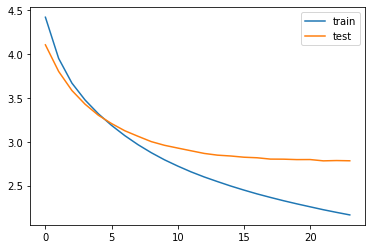

In [157]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기
- 테스트 단계
    - 정수 인덱스 행렬로 존재하던 텍스트 데이터 --> 실제 데이터 복원

In [158]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [160]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 문장의 
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [161]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [162]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [163]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# 추출적 요약(Extractive Summarize)
# seq2seq2 이용

In [164]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : supreme court monday referred five judge bench plea seeking declaration practice female community amounts female plea claimed practice violates right life dignity women association religious freedom defended saying different 
실제 요약 : sc plea on female to judge 
예측 요약 :  sc judge to women for


원문 : tribal couple stripped naked village rajasthan friday woman ex husband aides several villagers followed couple made videos incident later circulated social media police detained ex husband three others accused case victims mob 
실제 요약 : couple naked in rajasthan by woman ex husband 
예측 요약 :  couple woman for wearing in


원문 : actor aditya acquitted bandra metropolitan court assault case facing trial charged assaulting outside night club march later granted bail paying court reportedly observed evidence provided enough prove guilty 
실제 요약 : in assault case over of evidence 
예측 요약 :  court who suspended for assaulting time


원문 : rajiv kumar took vice chairman national institution india aa

예측 요약 :  kohli loses in test for st time


원문 : flying wimbledon courts wednesday causing players forced away american complained chair umpire said umpire complaint playing court said nose hair 
실제 요약 : of flying the at wimbledon 
예측 요약 :  footballer who out of


원문 : founder chinese live streaming platform former journalist become billionaire billion fortune shares last year owns platform million users china become largest market live streaming revenue expected reach billion according report 
실제 요약 : how did live make ex journalist billionaire 
예측 요약 :  china richest person in bn


원문 : harry potter among code names given eight protected witnesses national investigation agency kashmir terror funding case witnesses gave statements businessman granted bail thursday delhi high court got bail lawyer told court client provided witnesses statements 
실제 요약 : harry were in kashmir terror funding case 
예측 요약 :  harry to get married to


원문 : china pakistan decided extend china pakistan economi

# 추상적 요약 (Abstractive Summarize)
# 뉴스기사 Summarize하기 - summarize와 keyword함수 사용

In [293]:
import requests
from summa.summarizer import summarize

In [331]:
text = pd.DataFrame({"Text" : data["Text"],
                     "summary": 0,
                     "keyword" : 0})
text.index = range(0,len(text))
text

,Text,summary,keyword
0,new zealand defeated india wickets fourth odi ...,0,0
1,aegon life iterm insurance plan customers enjo...,0,0
2,pakistani singer rahat fateh ali khan denied r...,0,0
3,congress candidate shafia zubair ramgarh assem...,0,0
4,two minor cousins uttar pradesh gorakhpur alle...,0,0
...,...,...,...
74097,pakistan started building nearly kilometer fen...,0,0
74098,crpf jawan tuesday axed death sharp edged weap...,0,0
74099,uff yeh first song sonakshi sinha starrer upco...,0,0
74100,according reports new version science fiction ...,0,0


## Summarize

In [332]:
from tqdm import tqdm 
import time


from summa import keywords
for i in tqdm(range(len(text))):
    text["summary"][i] = summarize(Text[i])
    text["keyword"][i] = keywords.keywords(text["Text"][i])
text

  0%|          | 0/74102 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/o

,Text,summary,keyword
0,new zealand defeated india wickets fourth odi ...,,odi\nindia\nmatch\nconsecutive victories
1,aegon life iterm insurance plan customers enjo...,,life\nbenefit\ntax benefits\ninsurance\ninsure...
2,pakistani singer rahat fateh ali khan denied r...,,reads press release issued\nallegedly\nallegation
3,congress candidate shafia zubair ramgarh assem...,,seats\nramgarh assembly seat\ncandidate\nsingh
4,two minor cousins uttar pradesh gorakhpur alle...,,cousins\ngorakhpur\nfamily\ncommittee\nescape
...,...,...,...
74097,pakistan started building nearly kilometer fen...,,reports\nafghan militants reportedly\nborder\n...
74098,crpf jawan tuesday axed death sharp edged weap...,,jawan\nmaoists\nfair\nassailants\npolice\nbijapur
74099,uff yeh first song sonakshi sinha starrer upco...,,uff yeh\nfilm\nreleased\nrelease\nsong sonakshi
74100,according reports new version science fiction ...,,film\nreports\nreportedly\nkeanu reeves\npenn


# summarize가 안되는 이유 고찰

![image](https://user-images.githubusercontent.com/68802402/129713445-5dc85c91-c1cd-4d83-be6e-a5f121aa311b.png)

- 매트리스 시놉시스를 summarize한 경우는 위와같이 정상적이게 나왔다.
- ratio = 0.005로 요약을 해도 나왔고, words = 50으로 요약해도 정상작동했다.

## 그렇다면 왜 요약이 안됐을까?
1. 본문 내용을 하나하나 가져와서 summarize를 진행해도 똑같은 결과가 나온다. --> 코딩자체에 문제는 없음<br/>∴ text 본문 내용 자체가 짧기 때문이다.

![image](https://user-images.githubusercontent.com/68802402/129716285-336a7b3e-a2b4-4ce2-acd2-5c962efc412a.png)매트리스 시놉시스 text 길이

![image](https://user-images.githubusercontent.com/68802402/129717216-95b81827-514e-4951-9e6f-7f705945d6c0.png)뉴스기사 Text길이는 평균 251자



## 해결방법?
1. ratio를 높인다.
2. text를 늘린다. --> 영어를 못하니 포기

## 1.ratio를 높인다.

In [330]:
summarize(str(data["Text"]),ratio = 0.5)

'2        new zealand defeated india wickets fourth odi ...\n3        aegon life iterm insurance plan customers enjo...\n5        pakistani singer rahat fateh ali khan denied r...\n9        congress candidate shafia zubair ramgarh assem...\n98398    according reports new version science fiction ...'

* ratio를 높였지만 summarize가 가능한 문장이 그리 많지는 않은 것 같다.